## SIR Model

This notebook studies practical identifiability of the **SIR model**. We have translated original [Marisa Eisenberg](https://github.com/marisae/param-estimation-SIR) code to [Julia language](https://julialang.org/). The model is defined by the system of differential equations:

In [1]:
using DiffEqBase, OrdinaryDiffEq, Plots, NLopt, LikelihoodProfiler, DataFrames, Distributions

# ODE function
function ode_func(du,u,p,t)
   let (S, I, R, b, g) = (u[1],u[2],u[3],p[1],p[2])
    
       du[1] = -b*S*I
       du[2] = b*S*I - g*I
       du[3] = g*I
   end
end

ode_func (generic function with 1 method)

In [2]:
# we use times, data, parameters and initial values from
# https://github.com/marisae/param-estimation-SIR/blob/master/R/SIR_Example_Main.R#L11-L46
# to build an ODE Problem
times = [0., 7., 14., 21., 28., 35., 42., 49., 56., 63., 70., 77., 84., 91., 98.]
data = [97., 271., 860., 1995., 4419., 6549., 6321., 4763., 2571., 1385., 615., 302., 159., 72., 34.]
tspan = (0., 98.)

p0 = [0.4, 0.25, 1/80000]
u0(p,t) = [1-(data[1]*p[3]), data[1]*p[3], 0]

prob = ODEProblem(ode_func, u0, tspan, p0);

Now we solve the Initial Value Problem for nominal parametr values and plot the observed $ \frac{I}{kappinv} $ together with pseudo-experimental data

In [3]:
# solver algorithm, tolerances
solver_opts = Dict(
    :alg => AutoTsit5(Rosenbrock23()),
    :reltol => 1e-7,
    :abstol => 1e-14
)

# we are interested only in I
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=times,
    save_idxs = 2 # only I is observed
);

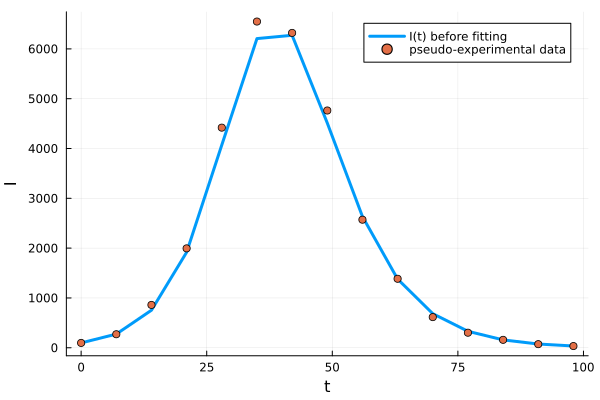

In [4]:
plot(sol.t, Vector(sol/p0[3]), xlabel = "t", ylabel = "I", label="I(t) before fitting", line=3);
scatter!(times,data, label = "pseudo-experimental data")

To fit parameters to pseudo-experimental data we use the following likelihood function:

$$ \Lambda = \sum_{i=1}^n y(t_i) - data_i*log(y(t_i)) $$

Here 
$n$ - number of observations (experimental data time points),
$data_i$ - experimental data,
$y(t_i)$ - numerical solution,

In [5]:
# for more details on the likelihood function choice see
# https://github.com/marisae/param-estimation-SIR/blob/master/R/SIR_Example_Main.R#L55-L78

function lk_func(
    pcur;
    prob=prob,
    solver_opts=solver_opts,
    times=times,
    data=data
) 
    # update prob with current parameter values
    probcur = remake(prob,p=pcur)
    
    # solve odes
    sol = solve(
        probcur, 
        solver_opts[:alg], 
        reltol=solver_opts[:reltol],
        abstol=solver_opts[:abstol],
        saveat=times,
        save_idxs = 2
    )
    
    # current parameter values
    params = abs.(probcur.p)
    
    # observable
    y = sol/params[3]
    
    # loss
    return sum(y) - sum(data.*log.(y))
end

lk_func (generic function with 1 method)

Now we fit parameters to the dataset with *NLopt* package. See [NLopt documentation](https://nlopt.readthedocs.io/en/latest) for details

In [6]:
# fitting algorithm
fitter_opts = Dict(
    :alg => :LN_NELDERMEAD
)

opt = Opt(fitter_opts[:alg], length(p0))
opt.min_objective = (p,grad) -> lk_func(p)

(loss,pfit,ret) = NLopt.optimize(opt, p0)

(-219911.21096113537, [0.39986451774133064, 0.2467743721339728, 1.2459655260616334e-5], :XTOL_REACHED)

Let's plot the fitted solution

In [7]:
probfit = remake(prob,p=pfit)
solfit = solve(
    probfit, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=times,
    save_idxs = 2
);

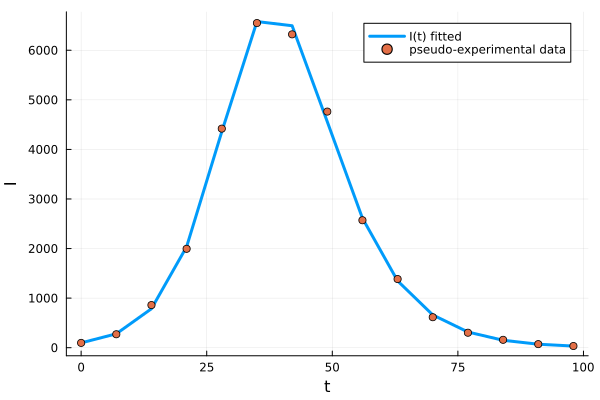

In [8]:
plot(times, Vector(solfit/pfit[3]), xlabel = "t", ylabel = "I", label="I(t) fitted", line=3);
scatter!(times,data, label = "pseudo-experimental data")

Let's use *LikelihoodProfiler* package to determine identifiable parameters and compute confidence intervals.
Please, look up [LikelihoodProfiler documentation](https://insysbio.github.io/LikelihoodProfiler.jl/latest/) for details

In [9]:
# threshold is chosen according to
# https://github.com/marisae/param-estimation-SIR/blob/master/R/SIR_Example_Main.R#L95
α = loss + cquantile(Chisq(3), 0.05)/2

intervals = Vector{ParamInterval}(undef,length(pfit))
for i in eachindex(pfit)
    
    intervals[i] = get_interval(
        pfit,
        i,
        lk_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        #theta_bounds = theta_bounds,
        #scan_bounds = scan_bounds[i],
        #local_alg = :LN_SBPLX,
        scale = fill(:log,length(pfit))
    )
    println(intervals[i]) 
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\evgen\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
left CP counter: 97    Time: 0:00:00 ( 6.97 ms/it)


ParamInterval(ParamIntervalInput([0.39986451774133064, 0.2467743721339728, 1.2459655260616334e-5], 1, LikelihoodProfiler.var"#28#30"{Int64}(1), lk_func, -219907.30359718375, [:log, :log, :log], [(0.0, Inf), (0.0, Inf), (0.0, Inf)], (1.0e-9, 1.0e9), 0.001, 0.001, :LN_NELDERMEAD, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}()), -219911.21096113537, :CICO_ONE_PASS, (EndPoint(0.3772590466726104, ProfilePoint[ProfilePoint(0.3772590466726104, -219907.48895164393, [0.3772590466726104, 0.2230306176900494, 1.4485487705324166e-5], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 97, 0.3772590466726104), EndPoint(0.4281161009698209, ProfilePoint[ProfilePoint(0.4281161009698209, -219907.33154866035, [0.4281161009698209, 0.2762423899675999, 1.0467642666015118e-5], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 114, 0.4281161009698209)))
ParamInterval(ParamIntervalInput([0.39986451774133064, 0.2467743721339728, 1.2459655260616334e-5], 2, LikelihoodProfiler.var"#28#30"

In [10]:
ENV["COLUMNS"]=120
df_res = DataFrame(
    Parameters = [:b, :g, :kappainv], 
    StatusLower = [k.result[1].status for k in intervals],
    StatusUpper = [k.result[2].status for k in intervals],
    CILower = [k.result[1].value for k in intervals],
    CIUpper = [k.result[2].value for k in intervals],
    FittedValues = pfit,
    NominalStartValues = p0
)
df_res

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,FittedValues,NominalStartValues
,Symbol,Symbol,Symbol,Float64,Float64,Float64,Float64
1,b,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.377259,0.428116,0.399865,0.4
2,g,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.222452,0.276362,0.246774,0.25
3,kappainv,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,1.05816e-5,1.4578e-5,1.24597e-5,1.25e-5


### Results

1. Estimated confidence intervals bounds are the same as estimated by the original Matlab/R code [param-estimation-SIR repo](https://github.com/marisae/param-estimation-SIR)
2. The dataset allows us to prcatically identify all three unknown parameters